<a href="https://colab.research.google.com/github/MayarAtef16/Image-Processing/blob/main/Mini_Project_1_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project Image Filtering and Hybrid Images Stencil Code
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import numpy as np
from numpy import pi, exp, sqrt
from skimage import io, img_as_ubyte, img_as_float32
from skimage.transform import rescale


def my_gaussian_kernel(cutoff_frequency: float) -> np.ndarray:
    """
    Generates a 2D Gaussian kernel with mean 0 and standard deviation `cutoff_frequency`.
    Args:
        cutoff_frequency: The standard deviation, in pixels, of the Gaussian blur.
    Returns:
        A 2D NumPy array representing the Gaussian kernel.
    """
    kernel_size = int(4 * cutoff_frequency + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1

    kernel = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - kernel_size // 2, j - kernel_size // 2
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * cutoff_frequency ** 2))

    kernel /= np.sum(kernel)

    return kernel

def my_imfilter(image: np.ndarray, filter: np.ndarray):
  """
  Your function should meet the requirements laid out on the project webpage.
  Apply a filter to an image. Return the filtered image.
  Inputs:
  - image -> numpy nd-array of dim (m, n, c) for RGB images or numpy nd-array of dim (m, n) for gray scale images
  - filter -> numpy nd-array of odd dim (k, l)
  Returns
  - filtered_image -> numpy nd-array of dim (m, n, c) or numpy nd-array of dim (m, n)
  Errors if:
  - filter has any even dimension -> raise an Exception with a suitable error message.
  """
  filtered_image = np.asarray([0])

  ##################
  # Your code here #
  # raise NotImplementedError('my_imfilter function in helpers.py needs to be implemented')

  ##################
  if filter.shape[0] % 2 == 0 or filter.shape[1] % 2 == 0:
        raise Exception("Filter dimensions must be odd")

    # Check if the input image is grayscale or color and get the number of channels
  is_gray = len(image.shape) == 2
  num_channels = 1 if is_gray else image.shape[2]

  # Pad the image borders to allow convolution at the borders
  filter_height, filter_width = filter.shape
  padding_height = filter_height // 2
  padding_width = filter_width // 2
  padded_image = np.pad(image, ((padding_height, padding_height), (padding_width, padding_width), (0, 0)), mode='constant')

    # Create a new image with the same shape as the input image
  filtered_image = np.zeros_like(image)

    # Apply the filter to each channel separately
  for channel in range(num_channels):
        # Extract the channel from the padded image
        padded_channel = padded_image[:, :, channel]

        # Apply the filter to the channel
        filtered_channel = np.zeros_like(padded_channel)
        for i in range(padding_height, padded_channel.shape[0] - padding_height):
            for j in range(padding_width, padded_channel.shape[1] - padding_width):
                patch = padded_channel[i - padding_height:i + padding_height + 1, j - padding_width:j + padding_width + 1]
                filtered_patch = np.sum(patch * filter)
                filtered_channel[i, j] = filtered_patch

        # Copy the filtered channel to the filtered image
        filtered_image[:, :, channel] = filtered_channel[padding_height:-padding_height, padding_width:-padding_width]

  return filtered_image
  #return filtered_image

def gen_hybrid_image(image1: np.ndarray, image2: np.ndarray, cutoff_frequency: float):
  """
   Inputs:
   - image1 -> The image from which to take the low frequencies.
   - image2 -> The image from which to take the high frequencies.
   - cutoff_frequency -> The standard deviation, in pixels, of the Gaussian
                         blur that will remove high frequencies.

   Task:
   - Use my_imfilter to create 'low_frequencies' and 'high_frequencies'.
   - Combine them to create 'hybrid_image'.
  """

  assert image1.shape == image2.shape

  # Steps:
  # (1) Remove the high frequencies from image1 by blurring it. The amount of
  #     blur that works best will vary with different image pairs
  # generate a gaussian kernel with mean=0 and sigma = cutoff_frequency,
  # Just a heads up but think how you can generate 2D gaussian kernel from 1D gaussian kernel
  #kernel = None
  kernel = my_gaussian_kernel(cutoff_frequency)
  # Your code here:
  #low_frequencies = None # Replace with your implementation
  low_frequencies = my_imfilter(image1, kernel)

  # (2) Remove the low frequencies from image2. The easiest way to do this is to
  #     subtract a blurred version of image2 from the original version of image2.
  #     This will give you an image centered at zero with negative values.
  # Your code here #
  #high_frequencies = None # Replace with your implementation
  blurred_image2 = my_imfilter(image2, kernel)
  high_frequencies = image2 - blurred_image2
  # (3) Combine the high frequencies and low frequencies
  # Your code here #
  #hybrid_image = None # Replace with your implementation
  hybrid_image = low_frequencies + high_frequencies
  #hybrid_image = np.clip(hybrid_image, 0, 1)
  # (4) At this point, you need to be aware that values larger than 1.0
  # or less than 0.0 may cause issues in the functions in Python for saving
  # images to disk. These are called in proj1_part2 after the call to
  # gen_hybrid_image().
  # One option is to clip (also called clamp) all values below 0.0 to 0.0,
  # and all values larger than 1.0 to 1.0.
  # (5) As a good software development practice you may add some checks (assertions) for the shapes
  # and ranges of your results. This can be performed as test for the code during development or even
  # at production!

  return low_frequencies, high_frequencies, hybrid_image

def vis_hybrid_image(hybrid_image: np.ndarray):
  """
  Visualize a hybrid image by progressively downsampling the image and
  concatenating all of the images together.
  """
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = 1 if hybrid_image.ndim == 2 else 3

  output = np.copy(hybrid_image)
  cur_image = np.copy(hybrid_image)
  '''
  for scale in range(2, scales+1):

    # add padding
    output = np.hstack((output, np.ones((original_height, padding, num_colors),
                                        dtype=np.float32)))
    # downsample image
    cur_image = rescale(cur_image, scale_factor, mode='reflect')
    # pad the top to append to the output
    pad = np.ones((original_height-cur_image.shape[0], cur_image.shape[1],
                   num_colors), dtype=np.float32)
    tmp = np.vstack((pad, cur_image))
    output = np.hstack((output, tmp))
  '''
  for i in range(1,scales):
    #add padding
        output = np.concatenate((output, np.ones((original_height, padding, num_colors))), axis=1)

        #dowsample image;
        cur_image = imresize(cur_image, scale_factor, 'bilinear').astype(np.float)/255
        #pad the top and append to the output
        tmp = np.concatenate((np.ones((original_height-cur_image.shape[0],cur_image.shape[1],num_colors)), cur_image), axis=0)
        output = np.concatenate((output,tmp), axis=1)
  return output

def load_image(path):
  return img_as_float32(io.imread(path))

def save_image(path, im):
  return io.imsave(path, img_as_ubyte(im.copy()))


In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


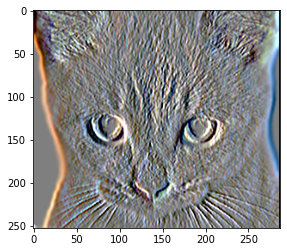

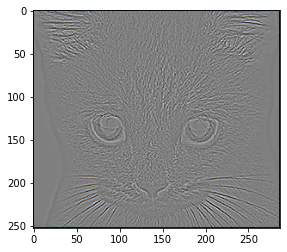

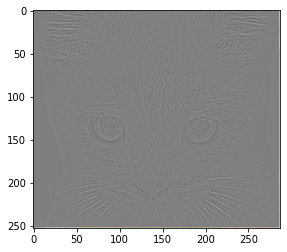

In [ ]:
# Project Image Filtering and Hybrid Images - Tests on my_imfilter function
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import os
from skimage.transform import rescale
import numpy as np
from numpy import pi, exp, sqrt
import matplotlib.pyplot as plt
#from helpers import load_image, save_image, my_imfilter,my_gaussian_kernel

resultsDir = '/content' + os.sep + 'results'
if not os.path.exists( resultsDir ):
    os.mkdir( resultsDir )

test_image = load_image('/content/data/cat.bmp')
test_image = rescale(test_image, 0.7, mode='reflect',channel_axis=2)

'''
Identity filter
This filter should do nothing regardless of the padding method you use.
'''
identity_filter = np.asarray([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
identity_image = my_imfilter(test_image, identity_filter)
plt.imshow(identity_image)
done = save_image('/content/results/identity_image.jpg', identity_image)


'''
Small blur with a box filter
This filter should remove some high frequencies.
'''
blur_filter = np.ones((3, 3), dtype=np.float32)
blur_filter /= np.sum(blur_filter, dtype=np.float32)  # making the filter sum to 1
blur_image = my_imfilter(test_image, blur_filter)
plt.imshow(blur_image)
done = save_image(resultsDir + os.sep + 'blur_image.jpg', blur_image)


'''
Large blur
This blur would be slow to do directly, so we instead use the fact that Gaussian blurs are separable and blur sequentially in each direction.
'''
# generate a gaussian kernel with any parameters of your choice. you may only in this case use a function
# from any library to generate the kernel such as: cv2.getGaussianKernel() then use the kernel to check your
# my_imfilter() implementation
# https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#Mat%20getGaussianKernel(int%20ksize,%20double%20sigma,%20int%20ktype)

## Slow (naive) version of large blur
# import time
# large_blur_filter = np.dot(large_1d_blur_filter, large_1d_blur_filter.T)
# t = time.time()
# large_blur_image = my_imfilter(test_image, large_blur_filter);
# t = time.time() - t
# print('{:f} seconds'.format(t))
##
'''
Oriented filter (Sobel operator)
'''
sobel_filter = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)  # should respond to horizontal gradients
sobel_image = my_imfilter(test_image, sobel_filter)

# 0.5 added because the output image is centered around zero otherwise and mostly black
sobel_image = np.clip(sobel_image+0.5, 0.0, 1.0)
plt.imshow(sobel_image)
done = save_image(resultsDir + os.sep + 'sobel_image.jpg', sobel_image)


'''
High pass filter (discrete Laplacian)
'''
laplacian_filter = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian_image = my_imfilter(test_image, laplacian_filter)

# added because the output image is centered around zero otherwise and mostly black
laplacian_image = np.clip(laplacian_image+0.5, 0.0, 1.0)
plt.figure(); plt.imshow(laplacian_image)
done = save_image(resultsDir + os.sep + 'laplacian_image.jpg', laplacian_image)

# High pass "filter" alternative
high_pass_image = test_image - blur_image
high_pass_image = np.clip(high_pass_image+0.5, 0.0, 1.0)
plt.figure(); plt.imshow(high_pass_image)
done = save_image(resultsDir + os.sep + 'high_pass_image.jpg', high_pass_image)


(361, 410, 3)


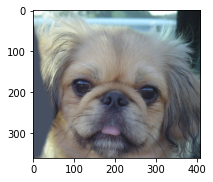

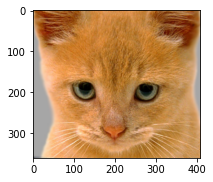

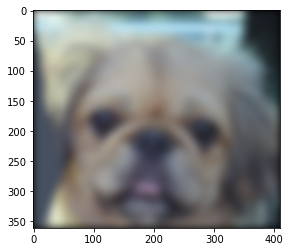

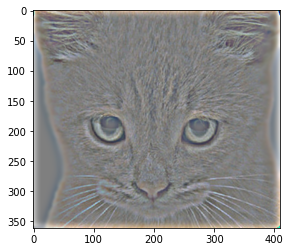

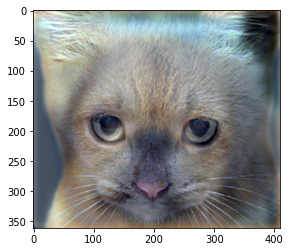

In [ ]:
# Project Image Filtering and Hybrid Images - Generate Hybrid Image
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
#from helpers import vis_hybrid_image, load_image, save_image, my_imfilter, gen_hybrid_image

# Before trying to construct hybrid images, it is suggested that you
# implement my_imfilter in helpers.py and then debug it using proj1_part1.py

# Debugging tip: You can split your python code and print in between
# to check if the current states of variables are expected or use a proper debugger.

## Setup
# Read images and convert to floating point format
image1 = load_image('/content/data/dog.bmp')
image2 = load_image('/content/data/cat.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3))
plt.imshow((image1*255).astype(np.uint8))
plt.figure(figsize=(3,3))
plt.imshow((image2*255).astype(np.uint8))

# For your write up, there are several additional test cases in 'data'.
# Feel free to make your own, too (you'll need to align the images in a
# photo editor such as Photoshop).
# The hybrid images will differ depending on which image you
# assign as image1 (which will provide the low frequencies) and which image
# you asign as image2 (which will provide the high frequencies)

## Hybrid Image Construction ##
# cutoff_frequency is the standard deviation, in pixels, of the Gaussian#
# blur that will remove high frequencies. You may tune this per image pair
# to achieve better results.
cutoff_frequency = 7

low_frequencies, high_frequencies, hybrid_image = gen_hybrid_image(image1, image2, cutoff_frequency)
print(hybrid_image.shape)
## Visualize and save outputs ##
plt.figure()
plt.imshow((low_frequencies*255).astype(np.uint8))
plt.figure()
plt.imshow(((high_frequencies+0.5)*255).astype(np.uint8))
plt.figure()
plt.imshow(hybrid_image)
#vis = vis_hybrid_image(hybrid_image)
#plt.figure(figsize=(20, 20))
#plt.imshow(vis)

save_image('/content/results/low_frequencies.jpg', low_frequencies)
#('/content/results/high_frequencies.jpg', high_frequencies+0.5)
#save_image('/content/results/hybrid_image.jpg', hybrid_image)
#save_image('/content/results/hybrid_image_scales.jpg', vis)
